# Osteocyte Network Analysis: Segmentation Comparison

This notebook implements an initial pipeline for analyzing osteocyte cell culture videos, as part of the MSc project *Characterisation and Physics-Based Modelling of Osteocyte Network Formation*. The focus is to compare region-based and edge-based segmentation methods to identify the most effective approach for segmenting osteocyte cells in 2D video data, per the scikit-image segmentation tutorial (https://scikit-image.org/docs/stable/user_guide/tutorial_segmentation.html).

## Objectives
- Read and preprocess video frames using OpenCV (`cv2`) with enhanced contrast and noise reduction.
- Compare four segmentation methods:
  1. **Otsu’s Thresholding (Region-Based)**: Global thresholding to separate cells from background.
  2. **Random Walker (Region-Based)**: Probabilistic segmentation for noisy or complex images.
  3. **Canny + Watershed (Edge-Based)**: Uses Canny edge detection and Watershed to separate cells.
  4. **Sobel + Watershed (Hybrid)**: Combines Sobel edge detection with region-based markers.
- Compute morphological descriptors (area, circularity, perimeter, centroid) for segmented cells.
- Track cell movements using Trackpy across a subset of frames.
- Visualize results with Matplotlib (static) and Napari (interactive).
- Evaluate methods using cell count, average area, circularity, and visual quality.

## Prerequisites
- Install libraries: `pip install opencv-python scikit-image trackpy matplotlib napari pandas scipy`.
- Make sure the video file (e.g., `wildtype/MLO-Y4 WT DMSO/Confluence_Single movie_30.03.2025_no mask_C2_3.mp4`) is in the working directory or adjust the path.
- Python 3.11 is used. Ensure scikit-image ≥0.19.0 for correct module imports.

In [126]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, morphology
from skimage.filters import threshold_otsu, sobel, gaussian, median
from skimage.feature import canny
from skimage.morphology import binary_closing, binary_opening, disk
from skimage.measure import label, regionprops
from skimage.segmentation import watershed, random_walker
from skimage.exposure import equalize_hist, rescale_intensity
from scipy.ndimage import distance_transform_edt
from skimage.feature import peak_local_max
import trackpy as tp
import pandas as pd
import napari
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

## Step 1: Read and Preprocess Video Frames

Load the video using OpenCV, convert frames to grayscale, apply histogram equalization for contrast enhancement, and Gaussian blur for noise reduction. Crop the bottom portion to remove overlays. Frames are stored for segmentation and tracking.

Loaded 48 frames.


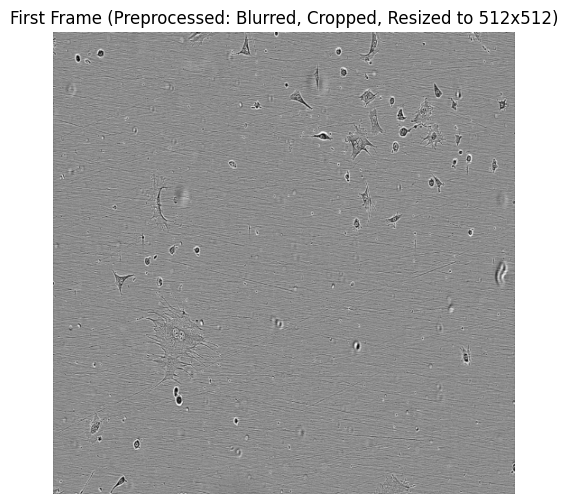

In [127]:
from skimage.transform import resize
# Path to the video file
video_path = '/Users/diana/Desktop/Osteocytes-Summer-Project-2025/2d-cell-cultures/Osteocytes culture/wildtype/MLO-Y4 WT DMSO/Confluence_Single movie_30.03.2025_no mask_C2_3.mp4'

# Open the video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise FileNotFoundError(f'Video file {video_path} not found. Please check the file path.')
if cap.get(cv2.CAP_PROP_FRAME_COUNT) == 0:
    raise ValueError(f'No frames detected in {video_path}. Check video integrity.')

# Read and process video frames
frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # Convert to grayscale
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Apply minimal Gaussian blur
    frame = gaussian(frame, sigma=0.5)  # Reduced blur to preserve details
    # Crop bottom portion (adjust based on video resolution, e.g., 860 rows)
    frame = frame[:860, :]
    if frame.size == 0:
        print('Warning: Cropped frame is empty. Adjust crop dimensions.')
        break
    # Resize to 512x512 for CPN compatibility
    frame = resize(frame, (512, 512), mode='constant', anti_aliasing=True)
    frames.append(frame)

cap.release()
if len(frames) == 0:
    raise ValueError('No frames processed. Check video or preprocessing steps.')
print(f'Loaded {len(frames)} frames.')

# Display first frame
plt.figure(figsize=(8, 6))
plt.imshow(frames[0], cmap='gray')
plt.title('First Frame (Preprocessed: Blurred, Cropped, Resized to 512x512)')
plt.axis('off')
plt.show()

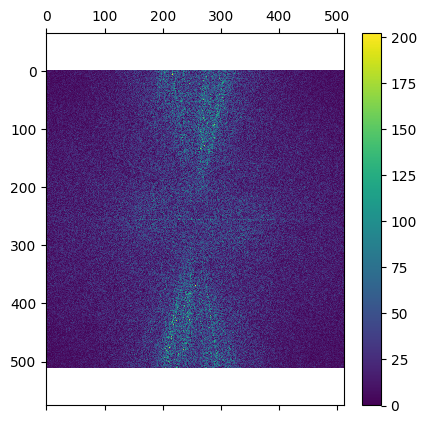

In [128]:
# tentative Fourier look at the data
# Prepare the frame

frame = frames[0].astype(float) # convert to float
img = frame -frame.mean() # substract the avg pixel value to centre the image data

# Compute the Fourier Transform
FFT = np.fft.fft2(img) # Fast Fourier Transform
FFT_shifted = np.fft.fftshift(FFT)  #bring the zero frequency at the centre of Fourier image
PS = np.absolute(FFT) # power spectrum
PS_shifted = np.fft.fftshift(PS)  #bring the zero frequency at the centre of Fourier image
plt.matshow(PS_shifted)
plt.axis("equal")
plt.colorbar()

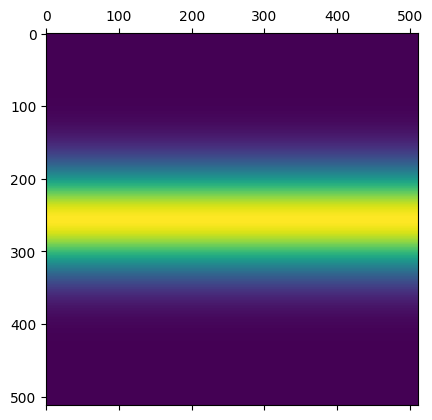

In [129]:
# Create an elliptical mask
shape = img.shape # get the frame's dimentions
rows, cols = np.indices(shape) # coordinates for each pixel 
# Define a mask
mask_radius = 250
semi_axis_major = 850
semi_axis_minor = 10
mask = ((rows-shape[0]//2)**2/semi_axis_minor**2+(cols-shape[1]//2)**2/semi_axis_major**2)< 1
mask = gaussian(mask, 50) # smooth the mask with gaussian blur
plt.matshow(mask) # show the mask as image

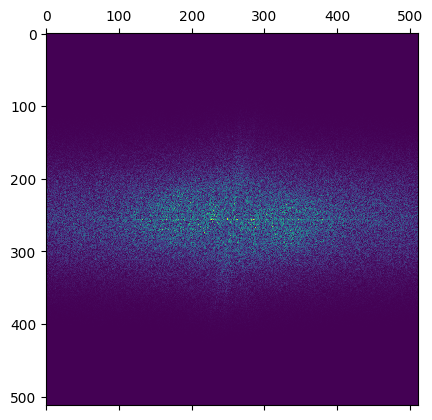

In [130]:
# Apply mask and visualize
masked_FFT = mask*FFT_shifted # keep only the ellipse frequencies
plt.matshow(np.abs(masked_FFT)) # display the masked spectrum's magnitude

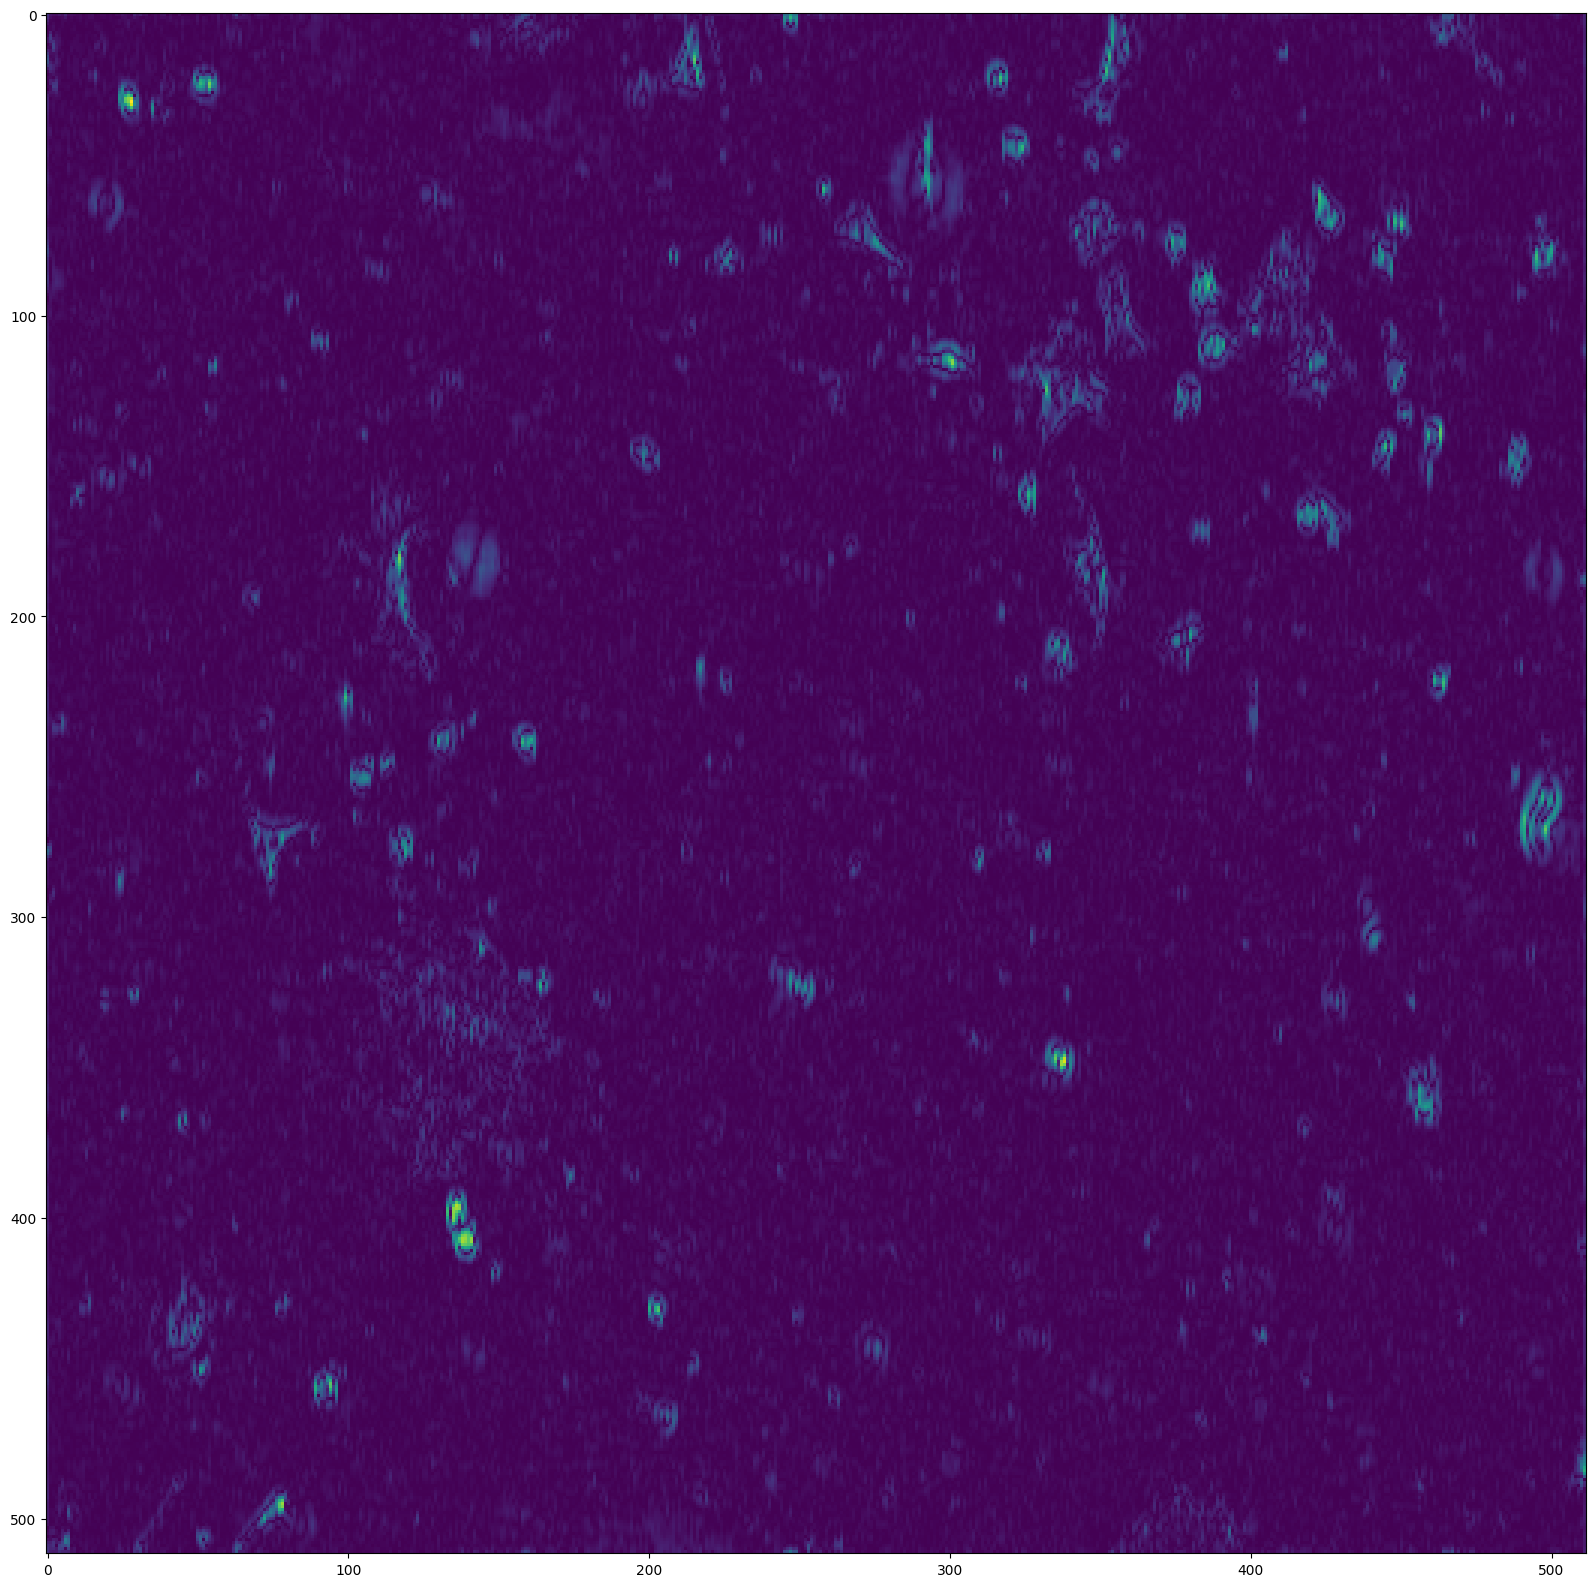

In [131]:
# Attempt image reconstruction
iFFT = np.fft.ifft2(masked_FFT) # an inverse Fourier Transform
plt.figure(figsize=(20,20)) 
plt.imshow(np.abs(iFFT)) # shows the reconstructed image's magnitude 

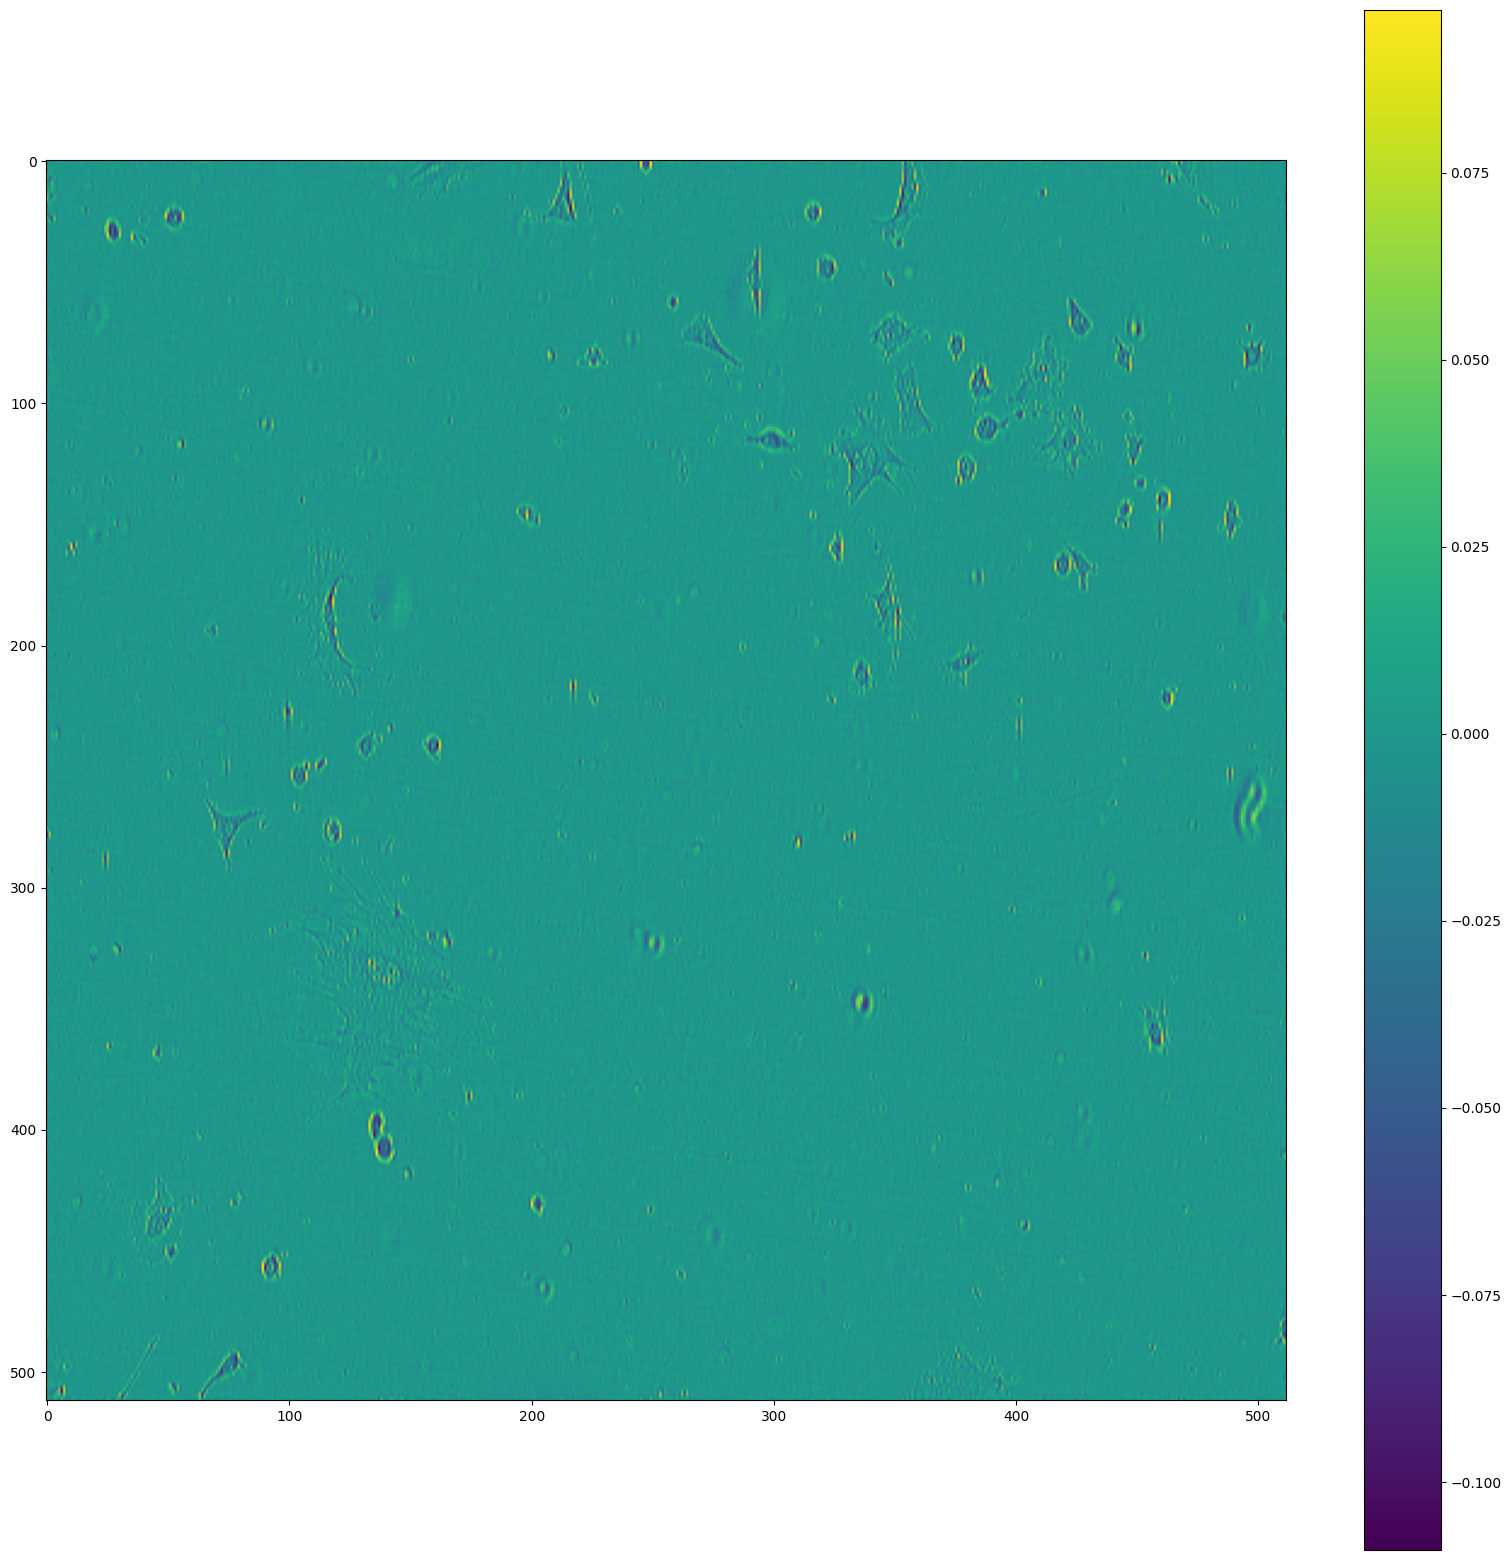

In [144]:
plt.figure(figsize=(20,20)) 
# Apply the elliptical mask 
product = FFT_shifted* mask
# Shift frequencies back to inverse FFT
reverse_shifted_product = np.fft.ifftshift(product)
# Reconstruct the image taking the real part
recovered_image = np.fft.ifft2(reverse_shifted_product).real
# Show the result
plt.imshow(recovered_image)
plt.colorbar()

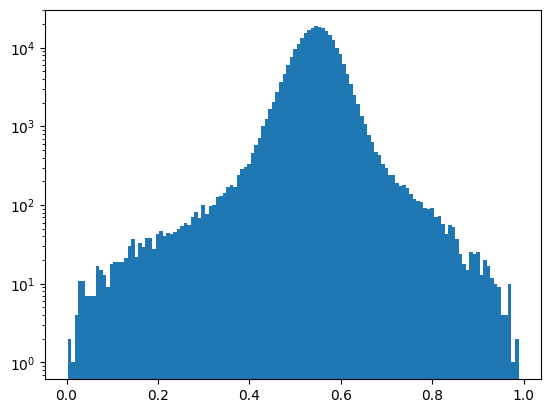

In [133]:
# Plot a histogram
plt.hist(frame.ravel(), 128);
plt.yscale('log')

In [134]:
# Test FFT with Parabolic Mask
# Create a parabolic mask
shape = img.shape
rows, cols = np.indices(shape)

# Initialize mask
mask = np.zeros(shape)

# Define parabolic parameters
center_row = shape[0] // 2
parabola_width = 150  # Controls the width of the parabolic opening
parabola_height = 30  # Controls how steep the parabola is

# Compute column indices relative to center
col_indices = cols[0, :] - shape[1] // 2

# Create top parabola (opens downward): rows = center_row + a * (cols / b)^2
top_parabola = center_row + parabola_height * (col_indices / parabola_width) ** 2
# Create bottom parabola (opens upward): rows = center_row - a * (cols / b)^2
bottom_parabola = center_row - parabola_height * (col_indices / parabola_width) ** 2

# Vectorized mask creation
# For each pixel (r, c), check if row r is between bottom_parabola[c] and top_parabola[c]
for c in range(shape[1]):
    mask[:, c] = (rows[:, c] >= bottom_parabola[c]) & (rows[:, c] <= top_parabola[c])

# Smooth the mask with Gaussian blur
mask = gaussian(mask, sigma=100)

<Figure size 800x600 with 0 Axes>

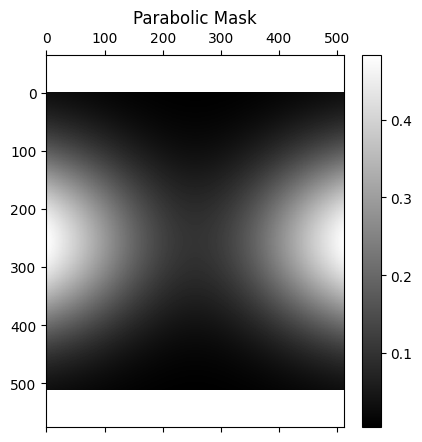

In [135]:
# Visualize the mask
plt.figure(figsize=(8, 6))
plt.matshow(mask, cmap='gray')
plt.title('Parabolic Mask')
plt.axis('equal')
plt.colorbar()
plt.show()

<Figure size 800x600 with 0 Axes>

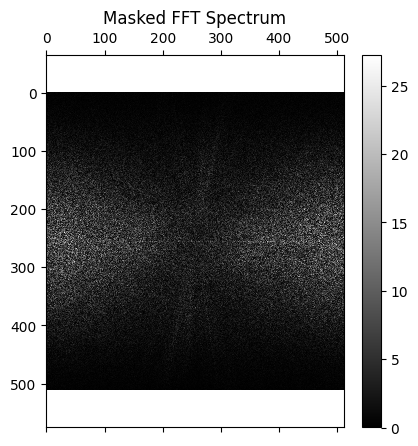

In [136]:
# Apply mask and visualize
masked_FFT = mask * FFT_shifted
plt.figure(figsize=(8, 6))
plt.matshow(np.abs(masked_FFT), cmap='gray')
plt.title('Masked FFT Spectrum')
plt.axis('equal')
plt.colorbar()
plt.show()

<Figure size 2000x2000 with 0 Axes>

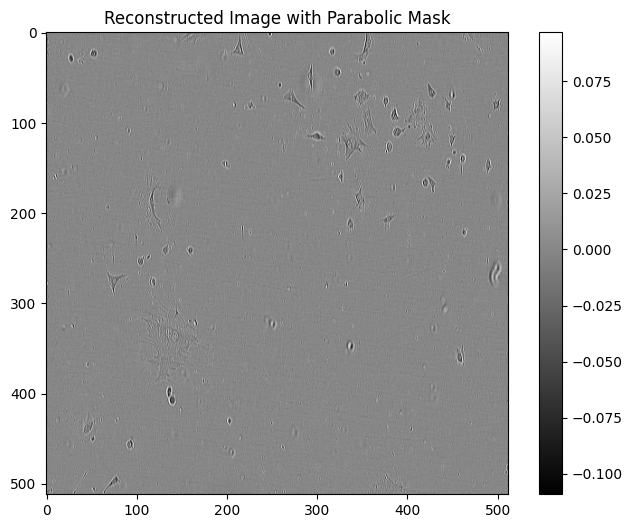

In [145]:
# Reconstruct the image
product = FFT_shifted * mask
reverse_shifted_product = np.fft.ifftshift(product)
recovered_image = np.fft.ifft2(reverse_shifted_product).real

# Show the reconstructed image
plt.figure(figsize=(8, 6))
plt.imshow(recovered_image, cmap='gray')
plt.title('Reconstructed Image with Parabolic Mask')
plt.colorbar()
plt.show()

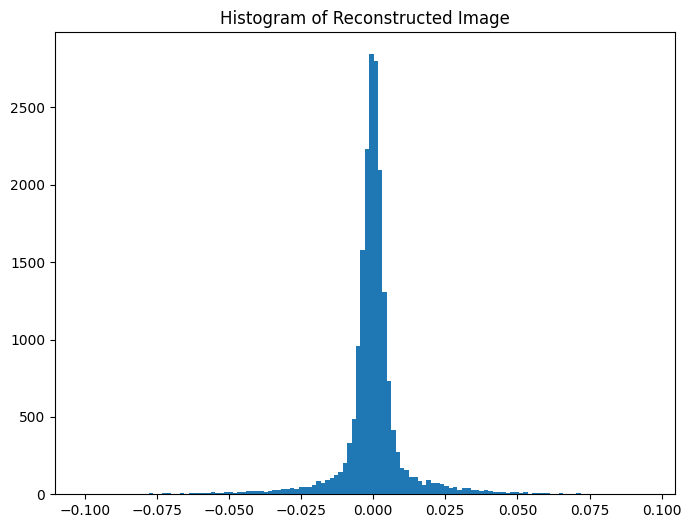

In [152]:
# Show histogram of the reconstructed image
plt.figure(figsize=(8, 6))
# focusing on top right corner where we have a mixture of cells and background
plt.hist(recovered_image[50:150,320:].ravel(), bins=128)
# plt.yscale('log')
plt.title('Histogram of Reconstructed Image')
plt.show()

In [139]:
# Cell Counting
image = recovered_image
image = rescale_intensity(image, in_range='image', out_range=(0, 1)) # adjust brightness and contrast
image = gaussian(image, sigma=0.5) # smooth the image
inverted_image = 1 - image # invert the image (cells - bright, background - dark)

# Adaptive thresholding
# Turn image into b&w (cells = 1, background = 0)
# Take small patches 51x51 pixels and decide what's a cell
try:
    thresh = threshold_local(inverted_image, block_size=51, offset=0.03)  # Softer threshold
    binary = inverted_image > thresh
except ValueError:
    binary = inverted_image > 0.25  # Manual fallback
binary_raw = binary.copy() # Save a copy

# Cleanup
# Remove tiny specks (noise) that aren't cells
selem = disk(2)  # Lighter to preserve cells
binary = binary_opening(binary, selem)
# Fill gaps within cell regions
binary = binary_closing(binary, selem)

# Watershed (separate touching cells)
binary_smooth = gaussian(binary.astype(float), sigma=1)  # Lighter smoothing
distance = distance_transform_edt(binary) # create a distance map (each white pixel's value is its dist to the nearest black background pixel)
# Find cell centres
# min_distance=2: Peaks are at least 2 pixels apart
# labels=binary: Only considers peaks within white (cell) regions.
# threshold_rel=0.1: Filters out weak peaks to avoid noise
local_maxi = peak_local_max(distance, min_distance=2, labels=binary, threshold_rel=0.1)  # More markers, filter weak maxima
# mark cell centres in a marker array
markers = np.zeros(distance.shape, dtype=np.int32)
if local_maxi.size > 0:
    markers[local_maxi[:, 0], local_maxi[:, 1]] = np.arange(1, len(local_maxi) + 1)
    labels = watershed(-distance, markers, mask=binary)
else:
    labels = label(binary)

# Count cells
# Only keep regions between 100 and 500 pixels
min_area = 100  # Include smaller cells
max_area = 500  # Exclude merged regions
labeled_cells = labels
regions = regionprops(labeled_cells) # Identify regions
regions = [r for r in regions if min_area <= r.area <= max_area]
# The number of valid regions
num_cells = len(regions)
print(f"Detected {num_cells} cells")

Detected 66 cells


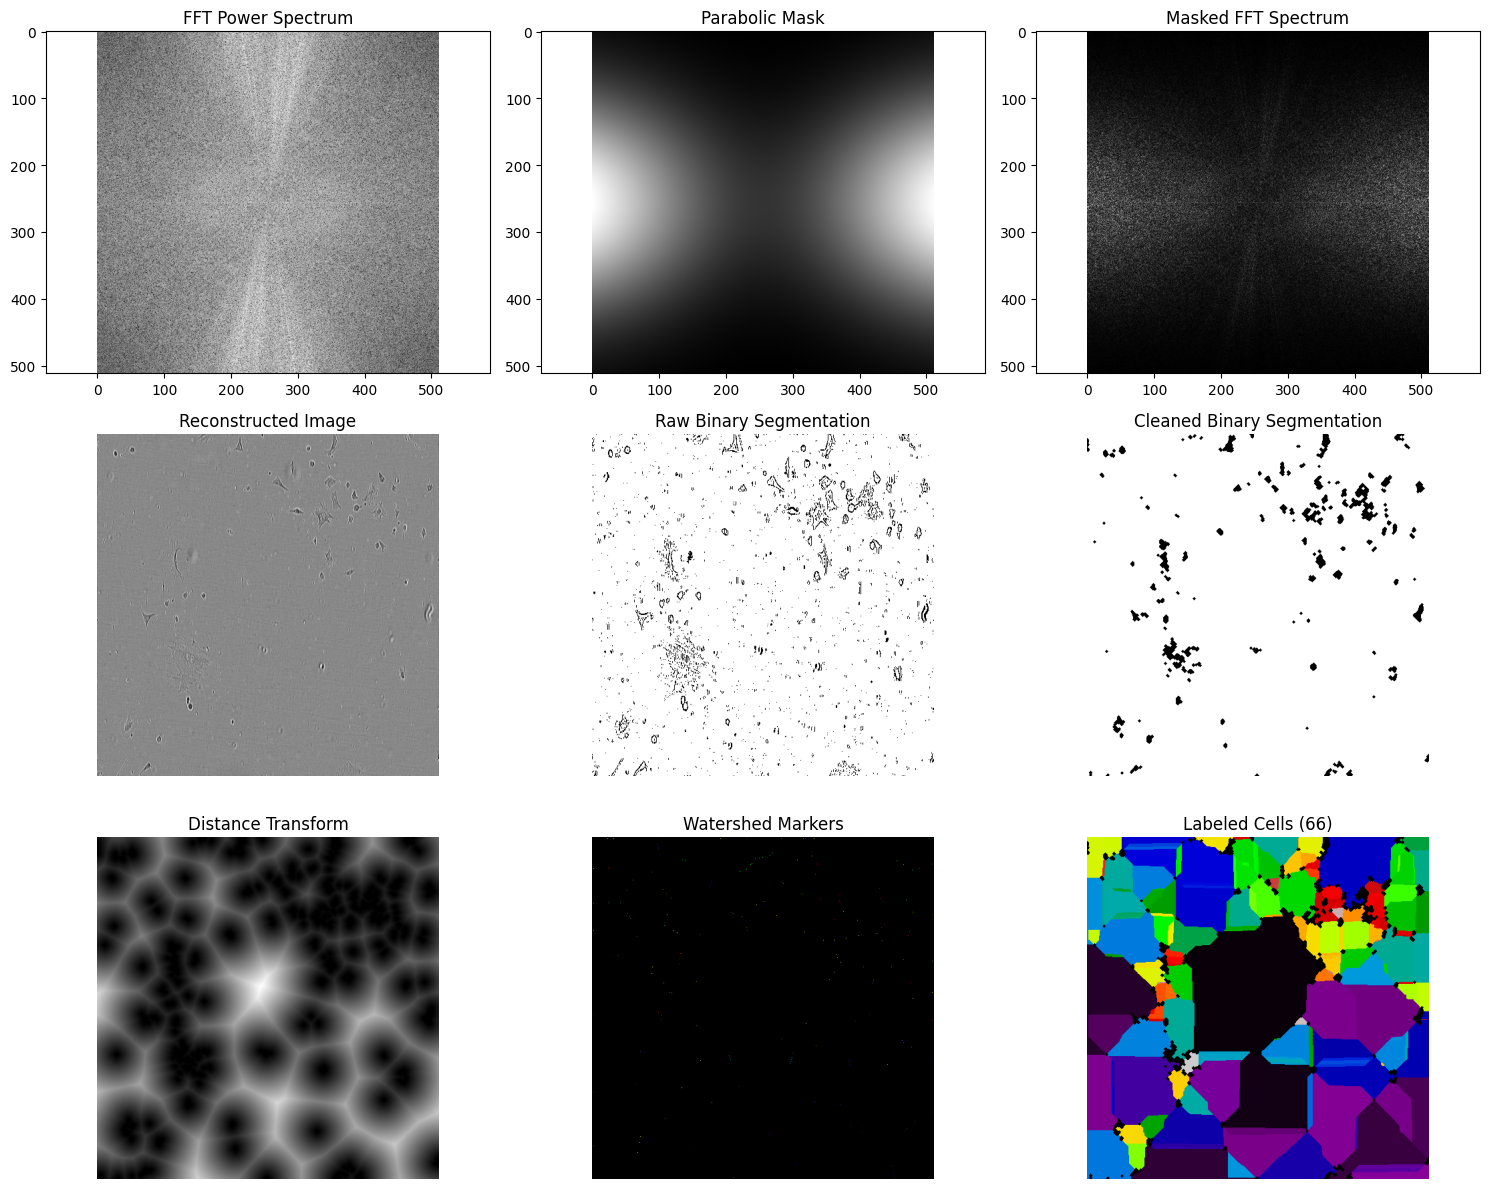

In [140]:
# Visualizations
plt.figure(figsize=(15, 12))

# FFT Power Spectrum
plt.subplot(3, 3, 1)
plt.imshow(np.log(PS_shifted + 1), cmap='gray')
plt.title('FFT Power Spectrum')
plt.axis('equal')

# Parabolic Mask
plt.subplot(3, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Parabolic Mask')
plt.axis('equal')

# Masked FFT
plt.subplot(3, 3, 3)
plt.imshow(np.abs(masked_FFT), cmap='gray')
plt.title('Masked FFT Spectrum')
plt.axis('equal')

# Reconstructed Image
plt.subplot(3, 3, 4)
plt.imshow(image, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

# Raw Binary
plt.subplot(3, 3, 5)
plt.imshow(binary_raw, cmap='gray')
plt.title('Raw Binary Segmentation')
plt.axis('off')

# Cleaned Binary
plt.subplot(3, 3, 6)
plt.imshow(binary, cmap='gray')
plt.title('Cleaned Binary Segmentation')
plt.axis('off')

# Distance Transform
plt.subplot(3, 3, 7)
plt.imshow(distance, cmap='gray')
plt.title('Distance Transform')
plt.axis('off')

# Watershed Markers
plt.subplot(3, 3, 8)
plt.imshow(markers, cmap='nipy_spectral')
plt.title('Watershed Markers')
plt.axis('off')

# Labeled Cells
plt.subplot(3, 3, 9)
plt.imshow(labeled_cells, cmap='nipy_spectral')
plt.title(f'Labeled Cells ({num_cells})')
plt.axis('off')

plt.tight_layout()
plt.show()

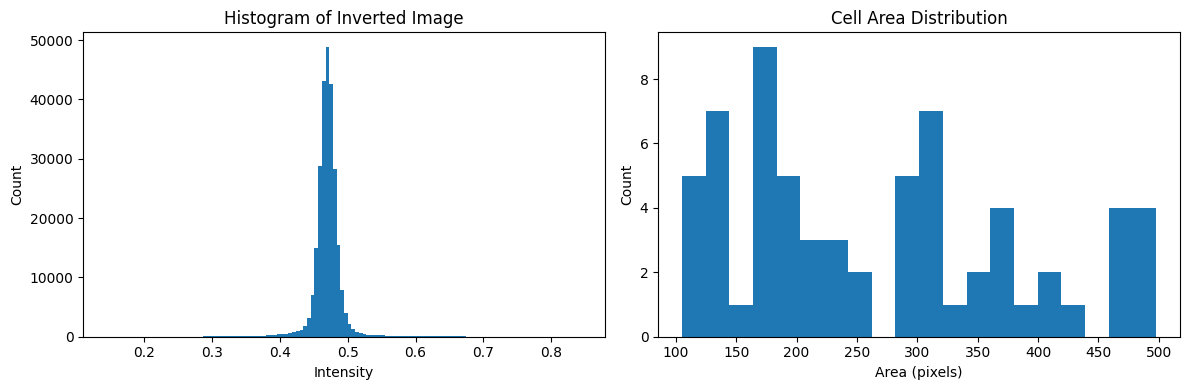

Cell areas (pixels): [486.0, 496.0, 199.0, 329.0, 305.0, 305.0, 297.0, 297.0, 400.0, 371.0, 319.0, 110.0, 475.0, 169.0, 167.0, 134.0, 257.0, 113.0, 169.0, 172.0, 198.0, 217.0, 109.0, 105.0, 358.0, 469.0, 192.0, 143.0, 170.0, 170.0, 130.0, 174.0, 196.0, 303.0, 303.0, 493.0, 156.0, 131.0, 373.0, 223.0, 174.0, 113.0, 438.0, 468.0, 358.0, 370.0, 287.0, 384.0, 310.0, 245.0, 233.0, 230.0, 498.0, 297.0, 130.0, 215.0, 139.0, 308.0, 415.0, 214.0, 289.0, 376.0, 178.0, 201.0, 139.0, 470.0]
Average cell area: 267.61 pixels


In [141]:
# Histograms
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(inverted_image.ravel(), bins=128)
plt.title('Histogram of Inverted Image')
plt.xlabel('Intensity')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist([r.area for r in regions], bins=20)
plt.title('Cell Area Distribution')
plt.xlabel('Area (pixels)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Print cell areas
areas = [region.area for region in regions]
print(f"Cell areas (pixels): {areas}")
if areas:
    print(f"Average cell area: {np.mean(areas):.2f} pixels")
else:
    print("No cells detected with area >= min_area.")

In [142]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

## Step 2: Compare Segmentation Methods

Test four segmentation methods on the first frame, including region-based (Otsu’s, Random Walker) and edge-based (Canny + Watershed, Sobel + Watershed), per the scikit-image tutorial (https://scikit-image.org/docs/stable/user_guide/tutorial_segmentation.html). Each method’s output is labeled, cleaned, and evaluated quantitatively (cell count, area, circularity) and visually.

Using device: cpu


/var/folders/kk/msr9gncd53l2vwhdqjy18xyr0000gn/T/ipykernel_15667/606489137.py:59: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  labeled_otsu = morphology.remove_small_objects(labeled_otsu, min_size=200)


Segmentation Validation:
Otsu’s Thresholding Results:
Number of cells: 1
Average area: 262144.00 pixels
Standard deviation of area: nan pixels
Average circularity: 0.79
Standard deviation of circularity: nan
Random Walker Results:
Number of cells: 2
Average area: 131072.00 pixels
Standard deviation of area: 178722.65 pixels
Average circularity: 0.02
Standard deviation of circularity: 0.02


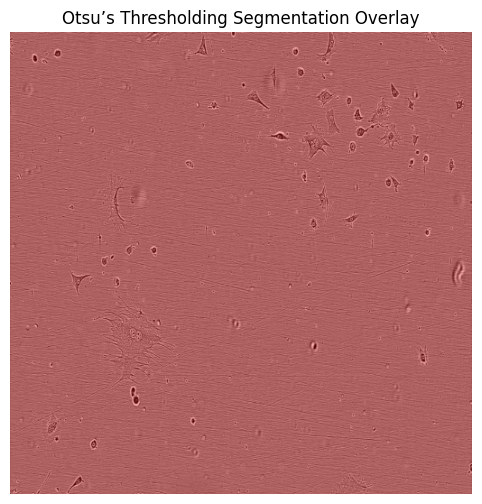

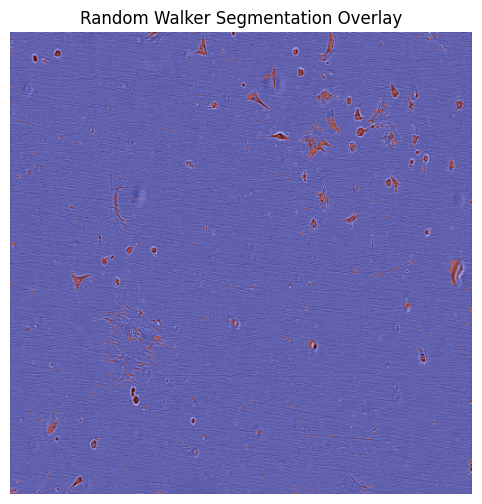

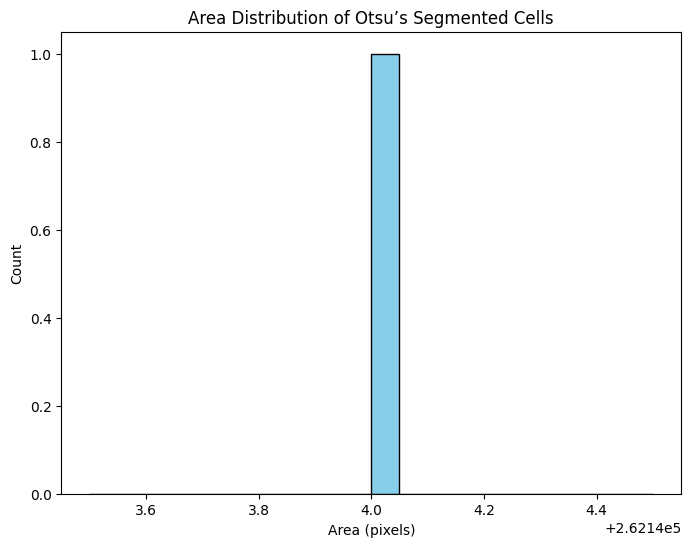

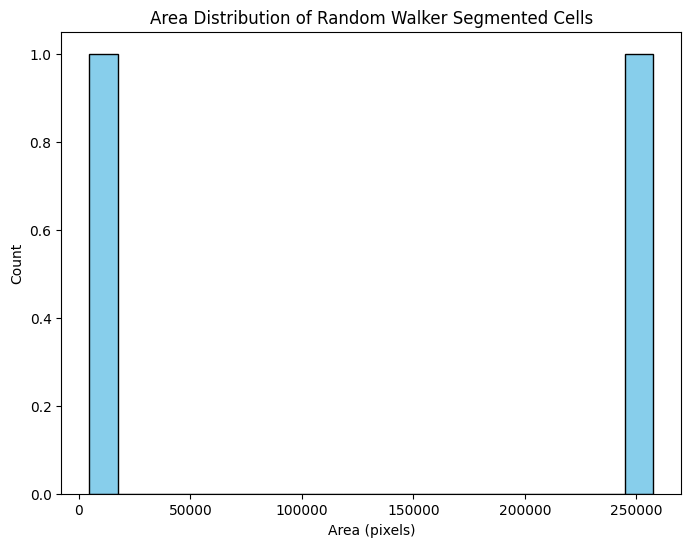

In [299]:
# Step 2: Cell Detection and Segmentation Comparison
from scipy.ndimage import distance_transform_edt
from skimage.feature import peak_local_max
import torch
import celldetection as cd
from skimage.color import label2rgb
import pandas as pd
from skimage.color import gray2rgb
%matplotlib inline

# Function to compute morphological descriptors
def compute_morphological_descriptors(labeled):
    props = measure.regionprops(labeled)
    morph_data = {
        'cell_id': [],
        'area': [],
        'perimeter': [],
        'circularity': [],
        'centroid_x': [],
        'centroid_y': []
    }
    for region in props:
        area = region.area
        perimeter = region.perimeter
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
        centroid = region.centroid
        morph_data['cell_id'].append(region.label)
        morph_data['area'].append(area)
        morph_data['perimeter'].append(perimeter)
        morph_data['circularity'].append(circularity)
        morph_data['centroid_x'].append(centroid[1])
        morph_data['centroid_y'].append(centroid[0])
    return pd.DataFrame(morph_data)

# Load pre-trained CPN model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
model = cd.fetch_model('ginoro_CpnResNeXt101UNet-fbe875f1a3e5ce2c', check_hash=True).to(device)
model.eval()

# Prepare first frame
frame = frames[0]
rgb_frame = gray2rgb(frame)
if rgb_frame.size == 0:
    raise ValueError('RGB conversion failed. Check frame data.')

# Normalize to [0.0, 1.0] as required by the model
x = cd.to_tensor(rgb_frame, transpose=True, device=device, dtype=torch.float32)
x = x / 255.0
x = x[None]


# 2.1: Otsu’s Thresholding (Region-Based)
thresh_otsu = threshold_otsu(frame)
binary_otsu = frame > thresh_otsu
binary_otsu = binary_closing(binary_otsu, disk(5))
binary_otsu = binary_opening(binary_otsu, disk(5))
labeled_otsu = measure.label(binary_otsu, connectivity=2)
labeled_otsu = morphology.remove_small_objects(labeled_otsu, min_size=200)

# 2.2: Random Walker (Region-Based)
markers_rw = np.zeros_like(frame, dtype=np.int32)
markers_rw[frame < thresh_otsu * 0.7] = 1  # Background
markers_rw[frame > thresh_otsu * 1.2] = 2  # Foreground
labeled_random_walker = random_walker(frame, markers_rw, beta=50, mode='bf')
labeled_random_walker = morphology.remove_small_objects(labeled_random_walker, min_size=200)

morph_df_otsu = compute_morphological_descriptors(labeled_otsu)
morph_df_random_walker = compute_morphological_descriptors(labeled_random_walker)

# Validation checks
print('Segmentation Validation:')

print('Otsu’s Thresholding Results:')
print(f'Number of cells: {len(morph_df_otsu)}')
print(f'Average area: {morph_df_otsu["area"].mean():.2f} pixels')
print(f'Standard deviation of area: {morph_df_otsu["area"].std():.2f} pixels')
print(f'Average circularity: {morph_df_otsu["circularity"].mean():.2f}')
print(f'Standard deviation of circularity: {morph_df_otsu["circularity"].std():.2f}')
print('Random Walker Results:')
print(f'Number of cells: {len(morph_df_random_walker)}')
print(f'Average area: {morph_df_random_walker["area"].mean():.2f} pixels')
print(f'Standard deviation of area: {morph_df_random_walker["area"].std():.2f} pixels')
print(f'Average circularity: {morph_df_random_walker["circularity"].mean():.2f}')
print(f'Standard deviation of circularity: {morph_df_random_walker["circularity"].std():.2f}')

# Common validation checks

morph_df = morph_df_random_walker  # Default to Random walker for validation

# Cell count check (expect 20–100 for osteocyte culture)
if len(morph_df) < 20:
    print('Warning: Low cell count. Adjust preprocessing or parameters.')
elif len(morph_df) > 100:
    print('Warning: High cell count. Check for over-segmentation or noise.')
# Area check (~100–10,000 pixels)
if morph_df['area'].mean() < 100 or morph_df['area'].mean() > 10000:
    print('Warning: Average area outside expected range. Review image scale or model.')
elif morph_df['area'].std() > morph_df['area'].mean() * 0.5:
    print('Warning: High area variance. Check for inconsistent region sizes.')
# Circularity check (0.3–0.8)
if morph_df['circularity'].mean() < 0.3 or morph_df['circularity'].mean() > 0.8:
    print('Warning: Circularity outside expected range. Check for irregular regions.')
elif morph_df['circularity'].std() > 0.3:
    print('Warning: High circularity variance. Check for fragmented or noisy regions.')

# Visualize segmentation overlays
overlay_otsu = label2rgb(labeled_otsu, image=frame, bg_label=0)
plt.figure(figsize=(8, 6))
plt.imshow(overlay_otsu)
plt.title('Otsu’s Thresholding Segmentation Overlay')
plt.axis('off')
plt.show()
overlay_random_walker = label2rgb(labeled_random_walker, image=frame, bg_label=0)
plt.figure(figsize=(8, 6))
plt.imshow(overlay_random_walker)
plt.title('Random Walker Segmentation Overlay')
plt.axis('off')
plt.show()

# Visualize area distributions
plt.figure(figsize=(8, 6))
plt.hist(morph_df_otsu['area'], bins=20, color='skyblue', edgecolor='black')
plt.title('Area Distribution of Otsu’s Segmented Cells')
plt.xlabel('Area (pixels)')
plt.ylabel('Count')
plt.show()
plt.figure(figsize=(8, 6))
plt.hist(morph_df_random_walker['area'], bins=20, color='skyblue', edgecolor='black')
plt.title('Area Distribution of Random Walker Segmented Cells')
plt.xlabel('Area (pixels)')
plt.ylabel('Count')
plt.show()